In [1]:
import base64
import hashlib 
from Crypto.Cipher import AES
from Crypto.Cipher import _mode_gcm
from Crypto.Random import get_random_bytes
from Crypto.Hash import SHA256
from Crypto.Protocol.KDF import PBKDF2
from Crypto.Random import get_random_bytes
from scipy.integrate import solve_ivp
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
def logistic_map(x, r):
    return r * x * (1 - x)

def lorenz_system(t, xyz, sigma, rho, beta):
    x, y, z = xyz
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

In [3]:
def secure_initialization_parameter(key, salt):
    return PBKDF2(key, salt, dkLen=32, count=1000000)


In [4]:
# Combined Chaotic System Function
def combined_chaotic_system(x0, y0, z0, r_logistic, sigma, rho, beta, num_rounds, key):
    round_keys = []
    x, y, z = x0, y0, z0

    for _ in range(num_rounds):
        x = logistic_map(x, r_logistic)

        t_span = (0, 0.1)
        x_avg, y_avg, z_avg = 0, 0, 0
        for _ in range(10):
            sol = solve_ivp(lorenz_system, t_span, [x, y, z], args=(sigma, rho, beta))
            x_avg += sol.y[0][-1]
            y_avg += sol.y[1][-1]
            z_avg += sol.y[2][-1]
        x_avg /= 10
        y_avg /= 10
        z_avg /= 10

        x_int = int(x_avg * 1000) % 256
        y_int = int(y_avg * 1000) % 256
        z_int = int(z_avg * 1000) % 256

        combined_value = x_int ^ y_int ^ z_int

        salt = get_random_bytes(16)
        stretched_key = secure_initialization_parameter(key, salt)

        hashed_key = SHA256.new(stretched_key + bytes([combined_value])).digest()
        round_keys.append(hashed_key)

    return round_keys

In [5]:
# Image Encryption Function
def encrypt_image(image_path, round_keys, img_number):

    img = Image.open(image_path)
    img_bytes = img.tobytes()
    original_image_size = img.size  

    nonce = get_random_bytes(12) 

    encrypted_data = b""
    start_time = time.time() 

    for i in range(len(round_keys)):

        cipher = AES.new(round_keys[i], AES.MODE_GCM, nonce=nonce)
    
        encrypted_round, tag = cipher.encrypt_and_digest(img_bytes)

        encrypted_data += encrypted_round

        img_bytes = encrypted_round

    encryption_time = time.time() - start_time  

    encrypted_img = Image.frombytes("RGB", original_image_size, encrypted_data)
    encrypted_img.save(f'outputs/encrypted_image_{img_number}.png')

    return encrypted_data, original_image_size, nonce, encryption_time


In [6]:
# Image Decryption Function
def decrypt_image(encrypted_data, round_keys, original_image_size, nonce, img_number):

    decrypted_data = b""
    start_time = time.time()  

    for i in range(len(round_keys)):

        cipher = AES.new(round_keys[i], AES.MODE_GCM, nonce=nonce)

        decrypted_round = cipher.decrypt(encrypted_data)

        decrypted_data += decrypted_round

        encrypted_data = decrypted_round

    decryption_time = time.time() - start_time 

    decrypted_img = Image.frombytes("RGB", original_image_size, decrypted_data)
    decrypted_img.save(f'outputs/decrypted_image_{img_number}.png')

    return decrypted_img, decryption_time

In [7]:
# Main execution
key = b'ThisIsA32ByteLongerKey'

num_rounds = 10

x0 = int.from_bytes(get_random_bytes(4), byteorder='big') / (2**32)
y0 = int.from_bytes(get_random_bytes(4), byteorder='big') / (2**32)
z0 = int.from_bytes(get_random_bytes(4), byteorder='big') / (2**32)

r_logistic = 3.9
sigma, rho, beta = 10, 28, 8/3
num_rounds = 10

In [8]:
# Generate round keys using combined chaotic system
round_keys = combined_chaotic_system(x0, y0, z0, r_logistic, sigma, rho, beta, num_rounds, key)

# Lists to store the time taken for each image
total_time = []

for img_number in range(1,5):
    # Encrypt the image, Decrypt the encrypted data, and measure times
    encrypted_data, original_image_size, nonce, encryption_time = encrypt_image(f'pics/test{img_number}.jpg', round_keys, img_number)
    decrypted_img, decryption_time = decrypt_image(encrypted_data, round_keys, original_image_size, nonce, img_number)
    total_time.append(encryption_time + decryption_time)

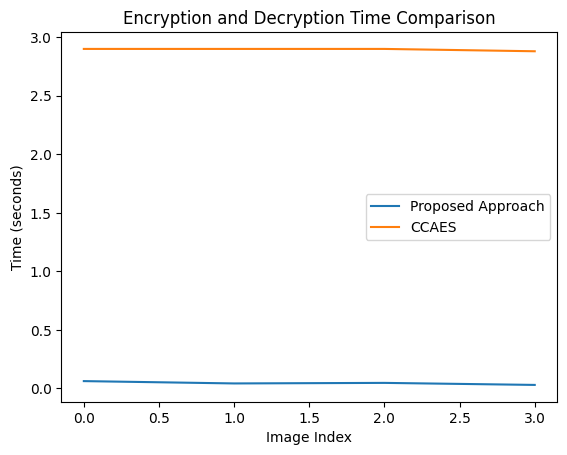

In [9]:
# Plotting the results

ccaes_line = [2.9, 2.9, 2.9, 2.88]

plt.plot(total_time, label='Proposed Approach')
plt.plot(ccaes_line, label='CCAES')

plt.xlabel('Image Index')
plt.ylabel('Time (seconds)')
plt.title('Encryption and Decryption Time Comparison')
plt.legend()
plt.show()

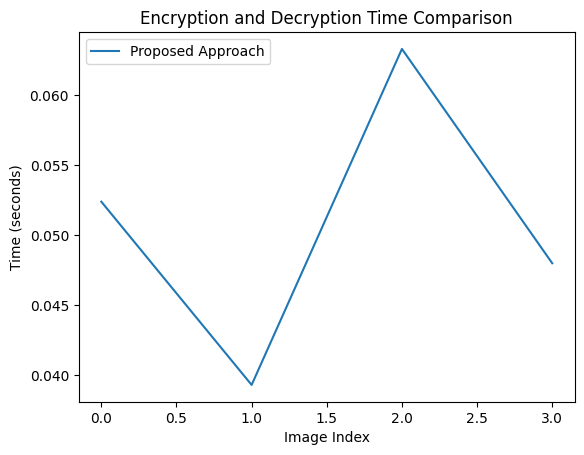

In [48]:
# Plotting the results
plt.plot(total_time, label='Proposed Approach')

plt.xlabel('Image Index')
plt.ylabel('Time (seconds)')
plt.title('Encryption and Decryption Time Comparison')
plt.legend()
plt.show()

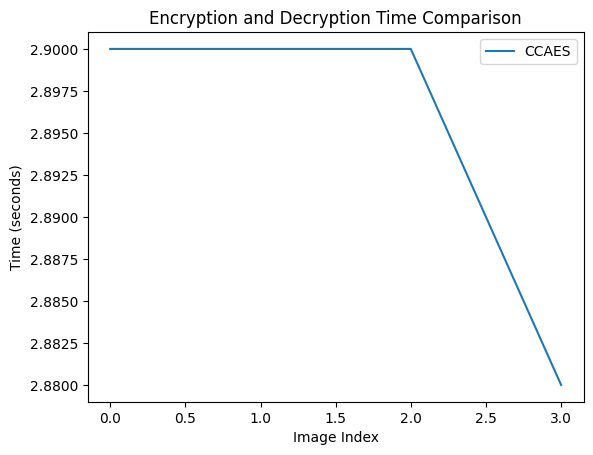

In [10]:
# Plotting the results

ccaes_line = [2.9, 2.9, 2.9, 2.88]

plt.plot(ccaes_line, label='CCAES')

plt.xlabel('Image Index')
plt.ylabel('Time (seconds)')
plt.title('Encryption and Decryption Time Comparison')
plt.legend()
plt.show()

NPCR and UACI

In [11]:
def calculate_metrics(original_image_path, encrypted_image_path):
    original_image = Image.open(original_image_path)
    encrypted_image = Image.open(encrypted_image_path)

    original_pixels = np.array(original_image)
    encrypted_pixels = np.array(encrypted_image)

    total_pixels = original_pixels.shape[0] * original_pixels.shape[1] * original_pixels.shape[2]

    # Calculate NPCR
    differing_pixels = np.count_nonzero(original_pixels != encrypted_pixels)
    npcr = (differing_pixels / total_pixels) * 100

    # Calculate UACI
    uaci = np.sum(np.abs(original_pixels - encrypted_pixels)) / (total_pixels * 255)

    # Calculate the absolute difference between pixel values
    pixel_difference = np.abs(original_pixels.astype(int) - encrypted_pixels.astype(int))

    # Calculate UACI
    uaci = np.mean(pixel_difference) / 255

    return npcr, uaci

# Example usage

for img_number in range(1, 5):
    npcr, uaci = calculate_metrics(f'pics/test{img_number}.jpg', f'outputs/encrypted_image_{img_number}.png')
    print(f'{img_number}:')
    print("NPCR:", npcr)
    print("UACI:", uaci)

1:
NPCR: 99.61191813151041
UACI: 0.28644417158139296
2:
NPCR: 99.6124267578125
UACI: 0.31223716985166466
3:
NPCR: 99.60886637369791
UACI: 0.32318440356285744
4:
NPCR: 99.61446126302084
UACI: 0.2983554416232639


Correlation Coefficient

In [12]:

# Calculate adjacent pixel correlations
def calculate_correlation(image_array):
    N = image_array.size
    x = image_array[:, :, 0].ravel()
    y = image_array[:, :, 1].ravel()
    z = image_array[:, :, 2].ravel()

    Ex = np.mean(x)
    Ey = np.mean(y)
    Ez = np.mean(z)

    cov_xy = np.mean((x - Ex) * (y - Ey))
    cov_yz = np.mean((y - Ey) * (z - Ez))
    cov_xz = np.mean((x - Ex) * (z - Ez))

    Dx = np.mean((x - Ex) ** 2)
    Dy = np.mean((y - Ey) ** 2)
    Dz = np.mean((z - Ez) ** 2)

    corr_xy = cov_xy / np.sqrt(Dx * Dy)
    corr_yz = cov_yz / np.sqrt(Dy * Dz)
    corr_xz = cov_xz / np.sqrt(Dx * Dz)

    return corr_xy, corr_yz, corr_xz

# Plot the correlation coefficients
def plot_correlation(corr_xy, corr_yz, corr_xz):
    channels = ['R-G', 'G-B', 'R-B']
    correlations = [corr_xy, corr_yz, corr_xz]

    plt.bar(channels, correlations, color=['red', 'green', 'blue'])
    plt.xlabel('Channel Pairs')
    plt.ylabel('Correlation Coefficient')
    plt.title('Correlation Coefficients of Adjacent Pixels')
    plt.ylim(-1, 1) 
    plt.axhline(0, color='black', linewidth=0.5)  
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.show()

for img_number in range(1, 5):
    
    encrypted_img = Image.open(f'outputs/encrypted_image_{img_number}.png')
    
    encrypted_array = np.array(encrypted_img)
    corr_xy, corr_yz, corr_xz= calculate_correlation(encrypted_array)
    print(f'{img_number}:')
    print(f'Horizontal: {corr_xy}')
    print(f'Vertical: {corr_yz}')
    print(f'Diagonal: {corr_xz}')
    print('\n')

1:
Horizontal: -0.0033927510323067474
Vertical: 0.001239724044836743
Diagonal: 0.0009509168664712299


2:
Horizontal: 0.004153720201415754
Vertical: -0.0028929143785260177
Diagonal: 0.00032271916492752293


3:
Horizontal: 0.002441811895146286
Vertical: 0.0005770012385588571
Diagonal: -0.005934866356983042


4:
Horizontal: -0.004792245242229345
Vertical: -0.001567799951212721
Diagonal: -0.006813567699077045




In [52]:
import cv2
import numpy as np

def calcEntropy(img):
    entropy = []

    hist = cv2.calcHist([img], [0], None, [256], [0, 255])
    total_pixel = img.shape[0] * img.shape[1]

    for item in hist:
        probability = item / total_pixel
        if probability == 0:
            en = 0
        else:
            en = -1 * probability * (np.log(probability) / np.log(2))
        entropy.append(en)

    sum_en = np.sum(entropy)
    return sum_en

print('Information Entropy')

for img_number in range(1, 5):
    img1 = cv2.imread(f'outputs/encrypted_image_{img_number}.png', cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(f'pics/test{img_number}.jpg', cv2.IMREAD_GRAYSCALE)

    entropy1 = calcEntropy(img1)
    entropy2 = calcEntropy(img2)


    print(f'{img_number}:')

    print(f'Original Image: {entropy2}')
    print(f'Encrypted Image: {entropy1}')

Information Entropy
1:
Original Image: [7.45298974]
Encrypted Image: [7.63533494]
2:
Original Image: [7.08850035]
Encrypted Image: [7.63272962]
3:
Original Image: [6.83241133]
Encrypted Image: [7.63039267]
4:
Original Image: [7.56345887]
Encrypted Image: [7.6301986]


Frequency vs Pixel Intensity Plot

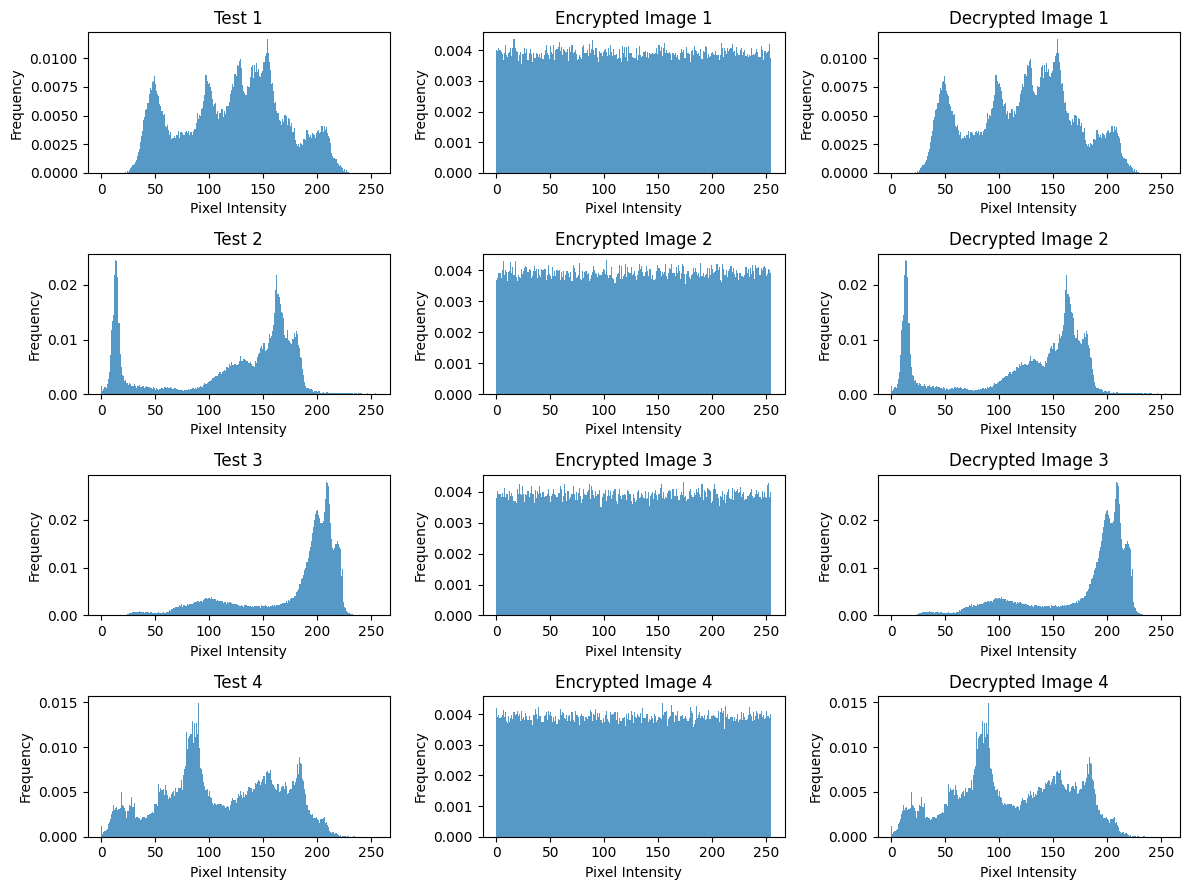

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_histogram(image_path, subplot_title):

    img = Image.open(image_path)
    pixel_values = np.array(img).ravel()
    plt.hist(pixel_values, bins=256, range=(0, 255), density=True, alpha=0.75)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(subplot_title)

plt.figure(figsize=(12, 9))

count = 1
for i in range(1, 5):
    plt.subplot(4, 3, count)
    plot_histogram(f'pics/test{i}.jpg', f'Test {i}')
    count += 1
    
    plt.subplot(4, 3, count)
    plot_histogram(f'outputs/encrypted_image_{i}.png', f'Encrypted Image {i}')
    count += 1
    
    plt.subplot(4, 3, count)
    plot_histogram(f'outputs/decrypted_image_{i}.png', f'Decrypted Image {i}')
    count += 1

plt.tight_layout()
plt.show()